[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tuankhoin/COMP90086-Practical-Solutions/blob/master/Week%206/workshop06_solution.ipynb)

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
path = "gdrive/My Drive/COMP90086 (T)/Week 6/"

Mounted at /content/gdrive


# COMP90086 Week 6: Deep CNN applications

***
In this worksheet, we'll see how to use pre-trained CNNs on [ImageNet](https://www.image-net.org/) to conduct classification and feature extraction. We will also try some visualisations of the higher-level features.


### Table of Contents

- Apply Deep CNN for classification

- Apply Deep CNN for feature extraction
     
- Visualizing intermediate activations

- Grad-CAM visualization

- Bonus: Guided Backprop Visualization

*The images used in this tutorial are from ImageNet or sharing copyright-free images.*

#### Assignment 1 Feedback
`[[1,0,1],[0,1,0],[1,0,1]]`
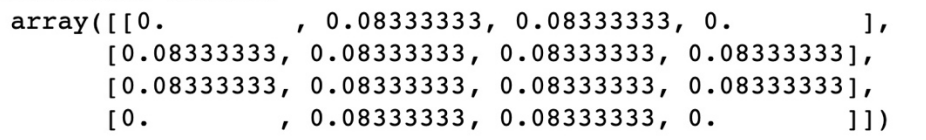
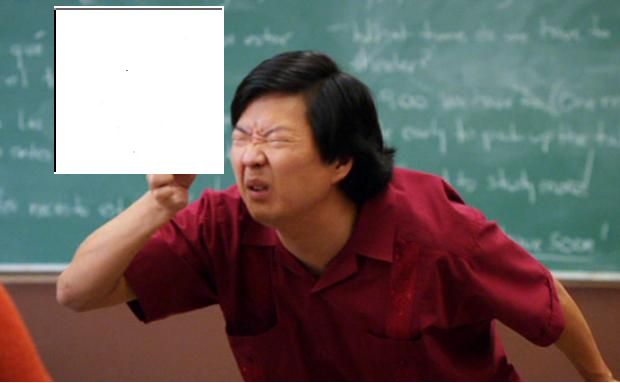
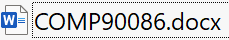

##### Common problems
- 1 kernel per orientation: inefficient (1 kernel is enough for 1 type, even both of them)
- Too many steps (1 convolution + 1 value filtering should be enough)
- Forgot to include result in report
- Forgot to include Maze 2
- Me reading your report: ⁉ (yeah I know the theories, but I don't know what you were thinking)

##### For next assignments
- Include as many supporting reasoning as possible, in a readable logic flow.
- $\LaTeX$ is my recommendation, and Overleaf is a good place to get started.

<img src='https://preview.redd.it/bl7vlaq7atx21.png?width=960&crop=smart&auto=webp&s=eeea300c6c2dcaa32e450400cf10009f4703f33f' alt='Source: Reddit' url='https://www.reddit.com/r/virginvschad/comments/bnr80i/the_virgin_microsoft_word_vs_the_chad_latex/' width=600/>

In [ ]:
from packaging import version

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# you may want to keep logging enabled when doing your own work
# disable Tensorflow warnings for this tutorial
import logging
tf.get_logger().setLevel(logging.ERROR) 
# disable Keras warnings for this tutorial
import warnings
warnings.simplefilter("ignore") 

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.2


## 1. Apply Deep CNN for classification

We will load a deep model, i.e., [MobileNet](https://arxiv.org/abs/1704.04861) with weights pre-trained on ImageNet, to conduct prediction on some example images. MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build light weight deep neural networks, which are popularly for mobile and embedded vision applications.

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions

# Load the model
model = MobileNet(weights='imagenet') #load weights pre-trained on large-scale imagenet dataset
# Default input shape has to be (224, 224, 3)
img_size = (224,224)

In [ ]:
# Summarize Model
print('\n'.join([f'{l.name}:\t\t\t {l.output_shape}' for l in model.layers]))

input_11:			 [(None, 224, 224, 3)]
conv1:			 (None, 112, 112, 32)
conv1_bn:			 (None, 112, 112, 32)
conv1_relu:			 (None, 112, 112, 32)
conv_dw_1:			 (None, 112, 112, 32)
conv_dw_1_bn:			 (None, 112, 112, 32)
conv_dw_1_relu:			 (None, 112, 112, 32)
conv_pw_1:			 (None, 112, 112, 64)
conv_pw_1_bn:			 (None, 112, 112, 64)
conv_pw_1_relu:			 (None, 112, 112, 64)
conv_pad_2:			 (None, 113, 113, 64)
conv_dw_2:			 (None, 56, 56, 64)
conv_dw_2_bn:			 (None, 56, 56, 64)
conv_dw_2_relu:			 (None, 56, 56, 64)
conv_pw_2:			 (None, 56, 56, 128)
conv_pw_2_bn:			 (None, 56, 56, 128)
conv_pw_2_relu:			 (None, 56, 56, 128)
conv_dw_3:			 (None, 56, 56, 128)
conv_dw_3_bn:			 (None, 56, 56, 128)
conv_dw_3_relu:			 (None, 56, 56, 128)
conv_pw_3:			 (None, 56, 56, 128)
conv_pw_3_bn:			 (None, 56, 56, 128)
conv_pw_3_relu:			 (None, 56, 56, 128)
conv_pad_4:			 (None, 57, 57, 128)
conv_dw_4:			 (None, 28, 28, 128)
conv_dw_4_bn:			 (None, 28, 28, 128)
conv_dw_4_relu:			 (None, 28, 28, 128)
conv_pw_4:			 (None,

In [ ]:
# Define a function to process the input image
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = image.load_img(img_path, target_size=size)
    # Convert the image pixels to a numpy array
    # if size is (224,224), `array` is a float32 Numpy array of shape (224, 224, 3)
    array = image.img_to_array(img)
    # Reshape data for the model
    # We add a dimension to transform our array into a "batch" of size (1, 224, 224, 3)
    # Convert the input to 4D input makes it the same as the training process,
    # with a placeholder, rows, cols, the number of colour channels as training process
    array = np.expand_dims(array, axis=0)
    # axis: Position in the expanded axes where the new axis (or axes) is placed.
    # axis = 0: insert axis at position 0 
    return array

### Make a prediction

***Hint: Try refreshing several times to see different examples***

wombat prediction:
49152/35363 [=========================================] - 0s 0us/step
wombat: 99.971%
beaver: 0.011%
brown_bear: 0.009%
guinea_pig: 0.002%
American_black_bear: 0.002%


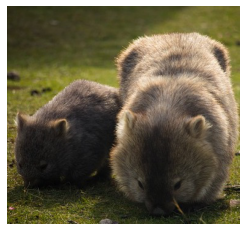

In [ ]:
img_lst = ['wallaby.jpeg','mushroom.png', "maltese.jpeg", "cat.jpg", "wombat.jpg", "koala.jpg", "dingo.jpg", "quokka.jpg"]
# select a random image name from the image list
img_name = np.random.choice(img_lst)

# Prepare image for the model
k_img = preprocess_input(get_img_array(path+img_name, size=img_size))
# predict the probability across all output classes
# model.predict(input) return the same data structure as your input
preds = model.predict(k_img)

print(img_name.split('.')[0],'prediction:')
# convert the probabilities to class labels and retrieve the top 5 highest probability result
for pred in decode_predictions(preds, top=5)[0]: 
    # print as labels: probability
    print('%s: %.3f%%' % (pred[1], pred[2]*100))

# display the image
im = plt.imread(path+img_name)
plt.imshow(im)
plt.axis('off')
plt.show()

### Small detour: Getting Help in a Jupyter Notebook
After importing a module, you can view help on the imported module by typing the module name followed by a question mark `?`

In [ ]:
MobileNet?

### Exercise 1

Load the MobileNet model with randomly **initialized weights** and conduct prediction on the above images. How do the predictions change?

wombat prediction:
toilet_tissue: 0.100%
sea_urchin: 0.100%
hog: 0.100%
zebra: 0.100%
sorrel: 0.100%


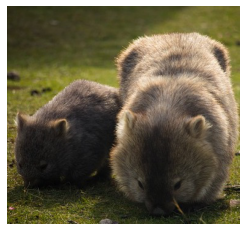

In [ ]:
## your code
model = MobileNet(weights=None) # random weights

# Prepare image for the model
k_img = preprocess_input(get_img_array(path+img_name, size=img_size))
# predict the probability across all output classes
preds = model.predict(k_img)

print(img_name.split('.')[0],'prediction:')
# convert the probabilities to class labels and retrieve the top 5 highest probability result
for pred in decode_predictions(preds, top=5)[0]: 
    # print as labels: probability
    print('%s: %.3f%%' % (pred[1], pred[2]*100))

# display the image
im = plt.imread(path+img_name)
plt.imshow(im)
plt.axis('off')
plt.show()

With random weights, the predictions of the network are random and not meaningful.

## 2 Use Deep CNN for feature extraction 

We will load a deep model, i.e., [ResNet50](https://arxiv.org/abs/1512.03385), to conduct prediction on some example images. The ResNet architecture was developed in 2015 and introduced *residual connections* - which replaces the standard parametric transform at each layer:

$$ \mathbf{x}_{l+1} = F_{\theta_l}(\mathbf{x}_l) $$

with a transformation of the rough form:

$$ \mathbf{x}_{l +1} = \varphi\left( \mathbf{x}_l + F_{\theta_l}(\mathbf{x}_l)\right), \, \varphi \, \text{some nonlinearity.}$$

The intuition here is that it is a more straightforward task for the network to learn the *residual* - the difference between the input and output of the layer. If little additional processing is required, then the learned transformation $F_{\theta_l}$ is free to be close to the identity.


### Load Deep CNN
Load the ResNet50 with weights pre-trained on ImageNet.

Note that we only go up to the last convolutional layer --we don't include fully-connected layers by setting `include_top=False`. The reason is that adding the fully connected layers forces you to use a fixed input size for the model (224x224, the original ImageNet format). By only keeping the convolutional modules, our model can be adapted to arbitrary input sizes.

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Build a ResNet50 model loaded with pre-trained ImageNet weights
# we can set the input size to be the size of the input image (not necessarily 224x224)
base_model = ResNet50(weights='imagenet', input_shape=[128,128,3],include_top=False) 
img_size = (128,128) # default input shape has to be (224, 224, 3)

# Print the names of layers
print('\n'.join( [base_model.get_layer(index = idx).name for idx in range(len(base_model.layers))] ))

input_12
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3

### Exercise 2: Use Pre-trained deep CNN for feature extraction

Use the above pre-trained model to extract feature from the image. Use the output of the "conv3_block4_out" layer as the feature output.

***Hint: create a model with `base_model.input` as the intput and the output of the `"conv3_block4_out"` as the output, then processs the input, and conduct prediction using `model.predict`.***


In [ ]:
## your code

# Extract features from an arbitrary intermediate layer with VGG19
model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv3_block4_out').output)

# Prepare image for the model
img_name = 'wallaby.jpeg'
x = preprocess_input(get_img_array(img_name, size=(128, 128)))

features = model.predict(x)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
print(features.shape)

(1, 16, 16, 512)


## 3 Visualizing intermediate activations

We will use the [VGG19 model](https://arxiv.org/abs/1409.1556) to extract features from raw images. The VGG19 model was a seminal architecture developed in 2014 that represented one of the earliest extremely deep model architectures, achieving state-of-the-art performance on standard vision benchmarks at the cost of expensive computation.

Today, it is regularly used as a standard vision 'backbone' - serving as a useful generic visual feature extractor that serves as a platform for task-specific downstream models to build on.

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

# Build a VGG19 model loaded with pre-trained ImageNet weights
model = VGG19(weights='imagenet') 

# default input shape has to be (224, 224, 3)
img_size = (224,224) 

574726144/574710816 [==============================] - 4s 0us/step


Loading an input image — a picture of a cat

(1, 224, 224, 3)


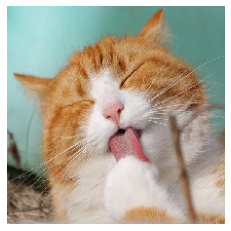

In [ ]:
# Pre-processing the image
img_tensor = get_img_array(path + 'cat.jpg', size=img_size) / 255.
  
# Print image tensor shape
print(img_tensor.shape)

# Display the image
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

In [ ]:
# Summarize Model
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# Extracts the ouput of the top 12 layers (excluding the input layer)
layer_outputs = [layer.output for layer in model.layers[1:13]]  
# Creates a model that will return these outputs, given the model input
activation_model = Model(inputs=model.input, outputs=layer_outputs)
# Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)
# Store the name of the layers
layer_names = []
for layer in model.layers[1:13]:
    layer_names.append(layer.name)

Visualization of the activation maps from first convolution layer. Initial layers identify low-level features. Different filters activate different parts of the image, like some are detecting edges, some are detecting background, while others are detecting just the outer boundary of the cat  and so on. At that stage, the activations retain almost all of the information present in the initial picture.

block1_conv1
(1, 224, 224, 64)


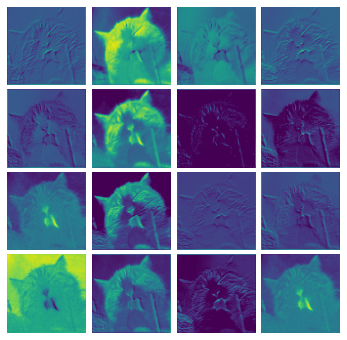

In [ ]:
# Getting Activations of the first convolution layer for the cat image input
first_layer_activation = activations[0]

print(layer_names[0])
# Shape of first layer activation
# It’s a 224 x 224 feature map with 64 channels
print(first_layer_activation.shape)

# Visualizing the first 16 channels in the 64 channels of the first convolution layer
fig = plt.figure(figsize=(6, 6))
for img in range(16):
    ax = fig.add_subplot(4, 4, img+1)
    ax = plt.imshow(activations[0][0, :, :, img], cmap='viridis')
    plt.axis('off')
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

We are now going to visualise each channel of these intermediate activation. Each channel encodes relatively independent features, so we will visualise these feature maps by plotting each channel independently as a 2D image. 

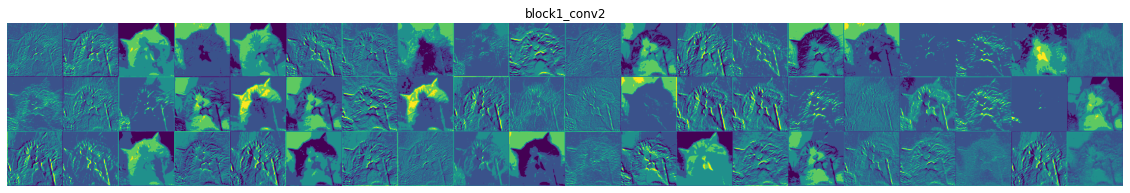

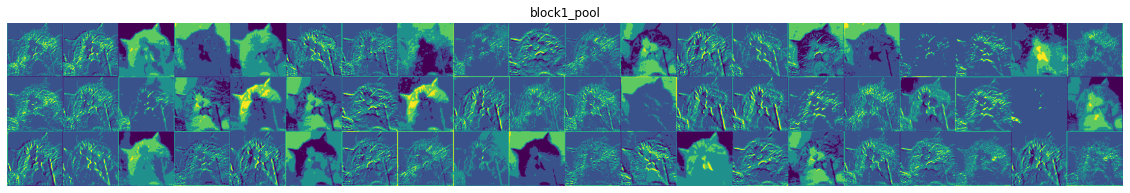

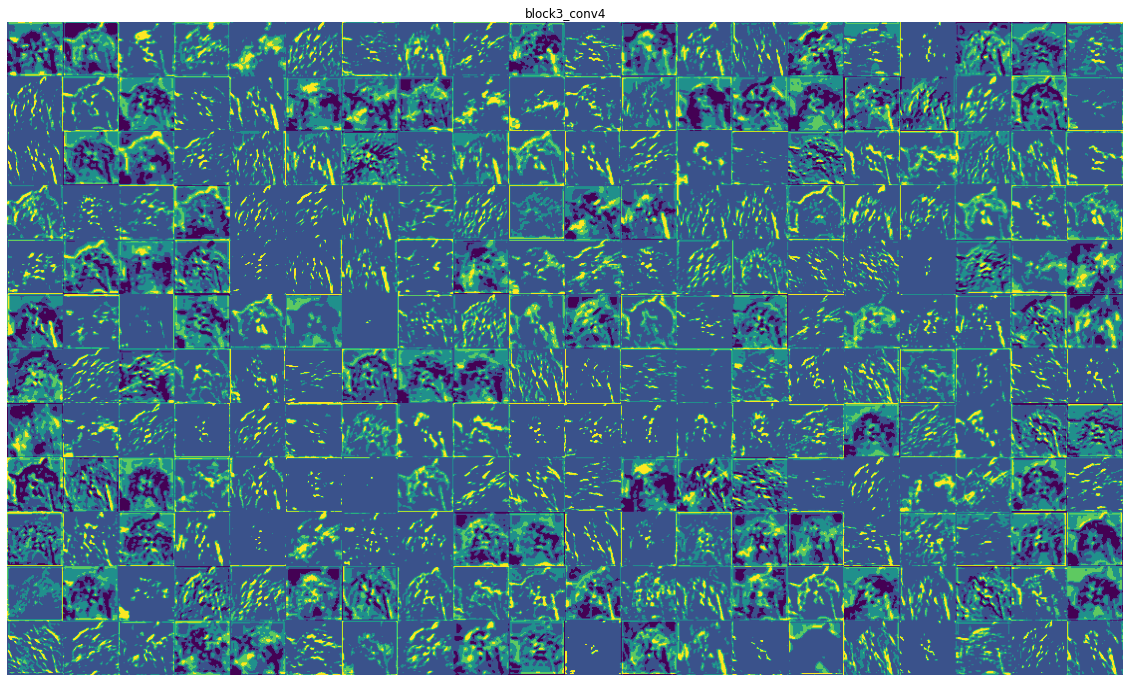

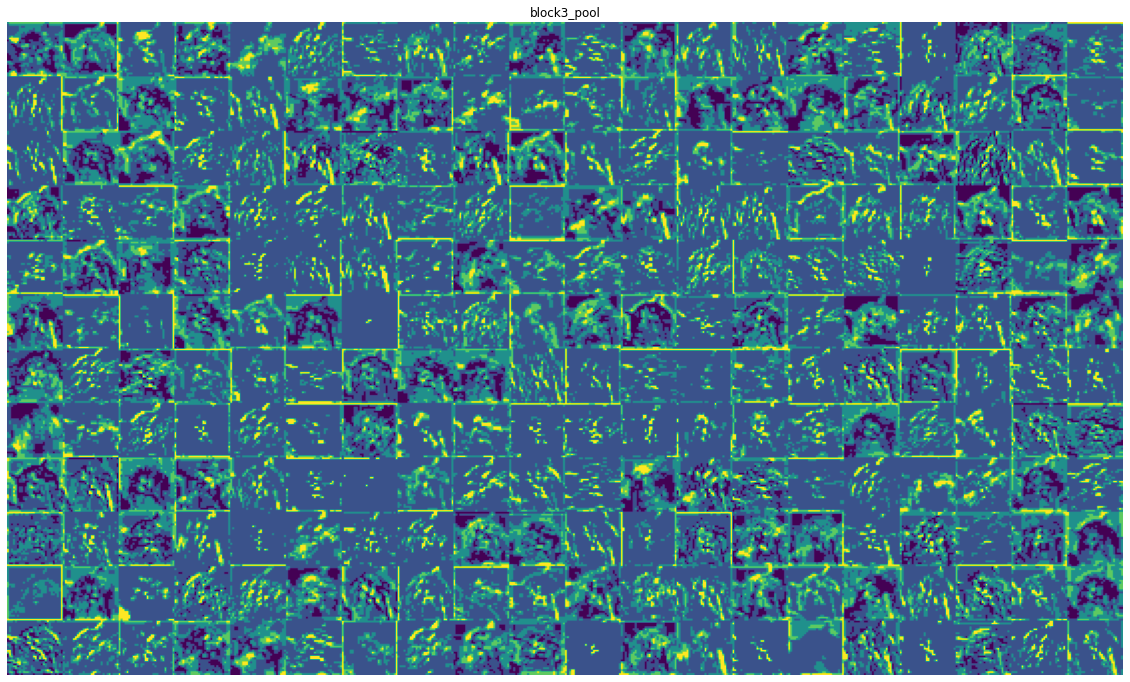

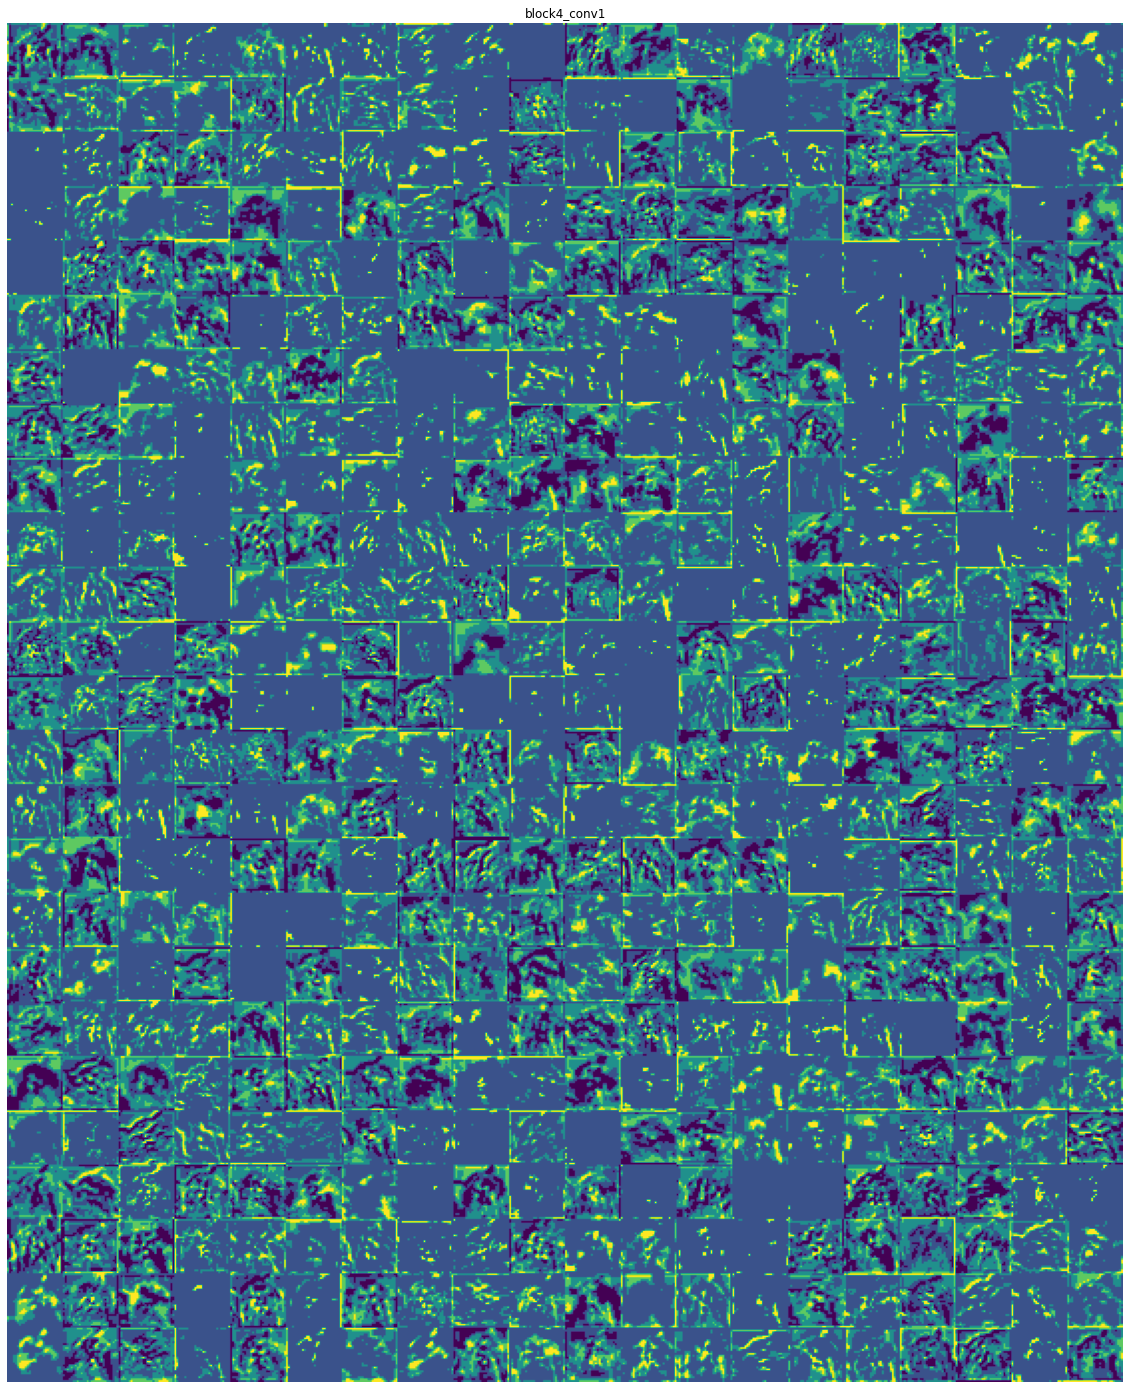

In [ ]:
img_per_row = 20
ids = [1,2,9,10,11]

# Displays the activations
for layer_name, layer_activation in zip([layer_names[i] for i in ids], [activations[i] for i in ids]):
    # Number of channels in the layer
    n_channel = layer_activation.shape[-1]
    # The feature map with shape (1, size, size, n_channel).
    size = layer_activation.shape[1]
    # Tiles the activation channels in this matrix
    n_col = n_channel // img_per_row
    display_grid = np.zeros((size * n_col, img_per_row * size))
    # Tiles each filter into a big horizontal grid
    for col in range(n_col):
        for row in range(img_per_row):
            channel_image = layer_activation[0,:, :,col * img_per_row + row]
            # Post-processes the feature to make it visually palatable
            channel_image = (channel_image-channel_image.mean())//channel_image.std()  
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            # Displays the grid
            display_grid[col * size : (col + 1) * size,
            row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

Looking at the activations of these convolutional layers, we can see that the layers close to the input layer learn very basic features, such as the edges and textures of the image. But as the layers go deeper, the activations become increasingly abstract and less visually interpretable. The network starts to learn more abstract features, leaving behind the general features of the image, which helps it to classify the image.

# 4 Grad-CAM visualization

In this section, we will display how to obtain a class activation heatmap for an image classification model. We do that using a method called [Grad-CAM](https://arxiv.org/abs/1610.02391). Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting important regions in the image for predicting the concept. 

For visualization purposes, we will continue to use the VGG19 model loaded in the previous section. Reference source for the content of this section: Keras.

### The Grad-CAM algorithm

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

You might want to check the model summary again to see what layers are there. We're using VGGG19 by the way.

In [ ]:
model.summary()

Next, we are going to make a prediction about our sample image. To get the values for `last_conv_layer_name` use `model.summary()` to see the names of all layers in the model.

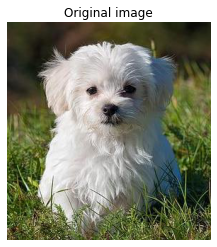

Maltese_dog: 18.357%
Class ID: [153]


In [ ]:
last_conv_layer_name = "block5_conv4"

img_name = path + "maltese.jpeg"

# Display the image
im = plt.imread(img_name)
plt.imshow(im)
plt.title('Original image')
plt.axis('off')
plt.show()

# Prepare image for the model
img_array = preprocess_input(get_img_array(img_name, size=img_size))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
for pred in decode_predictions(preds, top=1)[0]: 
    # print as labels: probability
    print('%s: %.3f%%' % (pred[1], pred[2]))
print("Class ID:" ,np.argsort(preds)[0, ::-1][:1])

Indeed there is a Maltese dog in the image. The `class ID` (index into the output layer) 153 stands for Maltese dog in [ImageNet with 1000 classes](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a#file-imagenet1000_clsidx_to_labels-txt-L154). But how does the network know this? Let's classify our images and see where the network "looks" when it does so.

In [ ]:
# In case you're too lazy to open a new link and do ctrl+f, this code gets class id from string
def get_idx(name):
  idx = [decode_predictions(preds, top=1000)[0].index(p) 
         for p in decode_predictions(preds, top=1000)[0] if p[1]==name]
  return np.argsort(preds)[0, ::-1][idx[0]]

get_idx('toilet_tissue')

999

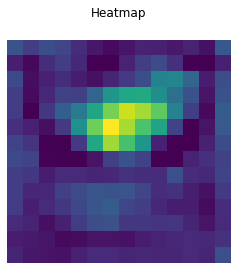

In [ ]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.title('Heatmap')
plt.axis('off')
plt.show()

In [ ]:
# Define a function to create a superimposed visualization
def display_gradcam(img_name, heatmap, alpha=0.4):

    # Load the original image
    img = image.load_img(img_name)
    img = image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display superimpose result
    plt.matshow(superimposed_img)
    plt.title('Superimpose')
    plt.axis('off')
    plt.show()

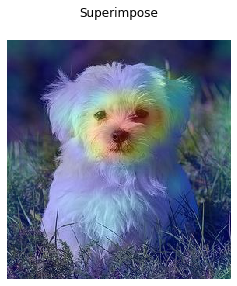

In [ ]:
display_gradcam(img_name, heatmap, alpha=0.4)

### Exercise 3: Choosing the target class (target prediction) for Grad-CAM

We will see how the grad cam explains the model's outputs for a multi-label image. Let's try an image with different fruits together, and see how the Grad-CAM behaves. Please generate Grad-CAM heatmaps for the top2 predicted  categories separately.

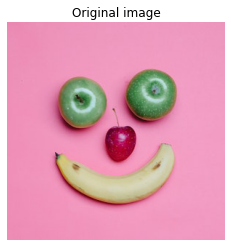

Granny_Smith: 10.539%
banana: 8.362%
Class ID: [948 954]


In [ ]:
img_name = "fruits.jpg"

# Display the image
im = plt.imread(img_name)
plt.imshow(im)
plt.title('Original image')
plt.axis('off')
plt.show()

# Prepare image for the model
img_array = preprocess_input(get_img_array(img_name, size=img_size))

# Print what the top2 predicted categories are
preds = model.predict(img_array)
for pred in decode_predictions(preds, top=2)[0]: 
    # print as labels: probability
    print('%s: %.3f%%' % (pred[1], pred[2]))
print("Class ID:" ,np.argsort(preds)[0, ::-1][:2])    

First, we generate class activation heatmap for "Granny_Smith," the class index is 948.

Granny_Smith


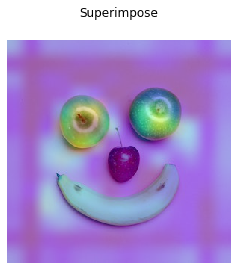

In [ ]:
## You code
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=948)
print("Granny_Smith")
display_gradcam(img_name, heatmap, alpha=0.6)

Then we generate class activation heatmap for "banana," the class index is 954.

banana


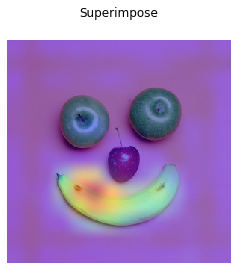

In [ ]:
## You code
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=954)
print("banana")
display_gradcam(img_name, heatmap, alpha=0.6)

# Bonus: Guided Backprop Visualization (and a few extra Tensorflow tips)

For visualization purposes, we will continue to use the VGG19 model.

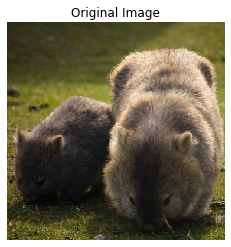

wombat: 26.929%
marmot: 16.983%
Class ID: [106 336]


In [ ]:
img_name = "wombat.jpg"
img = image.load_img(img_name, target_size=img_size)

# Display the image
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Prepare image for the model
preprocessed_input = preprocess_input(get_img_array(img_name, size=img_size))

# Print what the top2 predicted categories are
preds = model.predict(preprocessed_input)
for pred in decode_predictions(preds, top=2)[0]: 
    # print as labels: probability
    print('%s: %.3f%%' % (pred[1], pred[2]))
print("Class ID:" ,np.argsort(preds)[0, ::-1][:2])    

In [ ]:
# setting the last conv layer for VGG19
Layer = 'block5_conv4'

#### Copy a model
We will creat a model until last convolution layer from the VGG19 model. When we use the fully connected layer in the deep learning CNN model, we lose the spatial information which is retained by convolution layers.

In [ ]:
gb_model = Model(
    inputs = [model.inputs],    
    outputs = [model.get_layer(Layer).output]
)

#### Custom activation function

Now we define our own custom ReLU function for the backward pass. We use the `@tf.custom_gradient` decorator (see [here](https://www.tensorflow.org/api_docs/python/tf/custom_gradient)) to implement our own new “GuidedRelu” function for the backward pass. It allows the fine-grained control over the gradients for backpropagating non-negative gradients to have a more efficient or numerically stable gradient.

In [ ]:
@tf.custom_gradient
def GuidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

Afterwards, we substitute all old, original ReLU functions with our own “GuidedRelu” function.

In [ ]:
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
        layer.activation = GuidedRelu

#### Gradient record

With `tf.GradientTape()` (see [here](https://www.tensorflow.org/api_docs/python/tf/GradientTape)) we get the saliency map. We use the tf.GradientTape() to record the processed input image during the forward pass and calculate the gradients for the backward pass. Basically it is used to capture the gradients of the final (last) convolution layer.

In [ ]:
with tf.GradientTape() as tp:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tp.watch(inputs)
    outputs = gb_model(inputs)[0]
grads = tp.gradient(outputs,inputs)[0]

Finally, visualizing the guided backpropagation.

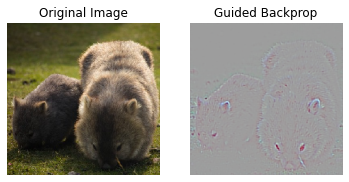

In [ ]:
gb_prop = grads
guided_back_viz = np.dstack((
            gb_prop[:, :, 0],
            gb_prop[:, :, 1],
            gb_prop[:, :, 2],
        ))       
guided_back_viz -= np.min(guided_back_viz)
guided_back_viz /= guided_back_viz.max()

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
 
plt.subplot(1,2,2)
plt.imshow(guided_back_viz)
plt.title("Guided Backprop")
plt.axis("off")

plt.show()

We can clearly visualise what the network focuses on - the most relevant image features are located around/inside the wombat's head. This is also in line with our intuition.